In [1]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [2]:
# AB: Taken directly from Adam's hh711_scatter_edf code

#need some cutouts and coordinates
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u

#easiest option would be using a library...assuming it works...but it doesn't?:(
# from statsmodels.distributions.empirical_distribution import ECDF


#quick function to compute EDF given a data set
#following: https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
def edf_calc(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)



#another method: follows https://stackoverflow.com/questions/3209362/how-to-plot-empirical-cdf-in-matplotlib-in-python
#     x = np.sort(data)
#     y = np.arange(len(x))/float(len(x))
    
    
#another another method
#before: following https://stackoverflow.com/questions/17821458/random-number-from-histogram to produce random numbers from an original histogram
#     #Defining the histogram and midpoints of each bin
#     hist = theory[:, 2]
#     bin_midpoints = (theory[:,1] + theory[:,0])/2.

#     #producing a CDF, which can be used to draw numbers from (which can't be intuitively done directly from a histogram)
#     cdf = np.cumsum(hist)
#     cdf = cdf / cdf[-1]

#     #generating random values, which are in turn used to take random values at a certain position in the cdf list...which are then used to pick values from the bin_midpoints (the actual possible x values)
#     values = np.random.rand(N)  	#this returns dimensions (m, n) for the array...or a single list as is here
#     value_bins = np.searchsorted(cdf, values)
#     random_from_cdf = bin_midpoints[value_bins]

#     return edf

# This dictionary defines a colormap in case you want to make a unique colormap?
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Creating a colormap using the dictionary
import matplotlib.colors as colors
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


#a plotting code to review what we're analyzing while in python
#data is the input data
#w is the wcs
#wcscond is True or False, True means the axes will be in RA/Dec, and False means axes in pixels
import matplotlib.pyplot as plt
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it's not bad
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')

SystemExit: 

C:\Users\abroa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


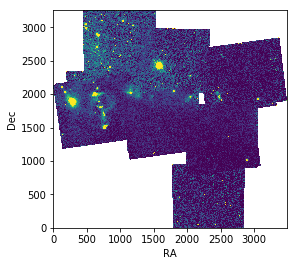

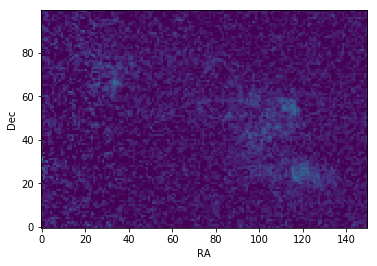

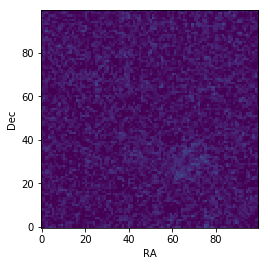

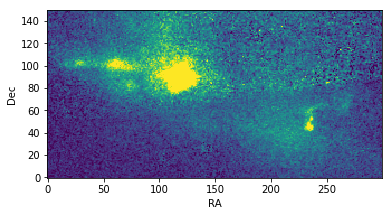

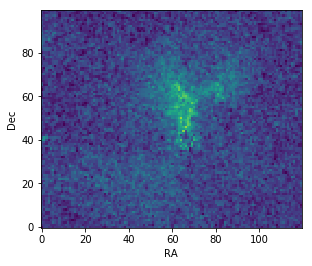

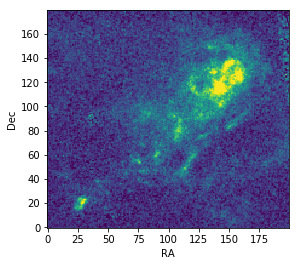

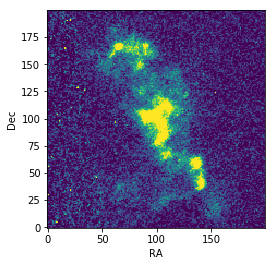

In [13]:
# AB: Taken directly from Adam's hh711_scatter_edf code, updated slightly to write out fits files for each cutout
# Creating the cutouts for each HH object and writing to fits file

#determining cutout coordinates for each knot...so far just do it by eye and in pixel space
#could probably do it in wcs coords, RA/DEC, but I couldn't get that working

#if you want to try this with various images, glob is the answer for finding files!
import glob
# filenames = glob.glob('../../Convolved_Images_Hub/*126_image*')
# print(filenames)

#some common packages
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D

#I just make a separate file with images of the 1.26 to 1.64 ratio
# file = '../../Convolved_Images_Hub/conv_126_image.fits'
# file = 'regrid_hub_dash_noleakage_ston_0.8.fits'  #this was the one I used before...
file = 'FITS_images/HST/164_dash_filled_final_Copy.fits' # AB: either 126_ or 164_

hdu1 = fits.open(file)        #import image
w = wcs.WCS(hdu1[1].header)   #get wcs coords
data = hdu1[1].data           #get data from hdu
#hdu1.close()                  #closing just in case? # AB: moved the location of the close

#plotting to review what data looks like, need to send wcs regardless
#probably need to make wcs an optional param...
implot(data, w, False, 0.3)  # AB: change the last number value so plot was easier to see
#     sys.exit()


#initial guesses for cutout coords of scattered(?) light
#guessing 
# coords_list = [[(90, 700), (85, 130)], 
#               [(580, 645), (40, 80)],
#               [(480, 600), (30, 100)],
#               [(730, 550), (160, 160)],
#               [(420, 500), (180, 80)],
#               [(665, 420), (100, 100)],
#               ]

#actual coords of knots HH 7 - 11
# AB: updated to values for lower region
coords_list = [[(1995-6, 1460+1), (100, 150)],
              [(2120-6, 1371+1), (100, 100)],
              [(1200-6, 2000+1), (150, 300)], 
              [(1480-6, 1950+1), (100,120)],
              [(2010-6, 1920+1), (180, 200)],
              [(2480-6, 1960+1), (200, 200)],
              ]

#plotting cutouts, probably better loops for this
for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]
               
    #cutting out coordinates using Cutout2D
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs

    #plotting *cutout*
    implot(datacut, wcscut, False, 0.3) 
    #plt.savefig('knot'+str(i+1)) #+6 b/c of indexing, would have to adjust that and path
    
    # AB: add on to try and save the cutouts as a fits file to do the division
    hdu1[1].data = datacut
    hdu1[1].header.update(wcscut.to_header())
    hdu1[1].writeto('FITS_images/cutouts/164_knot'+str(i+1)+'_shift.fits', overwrite=True)

hdu1.close()
    
sys.exit()


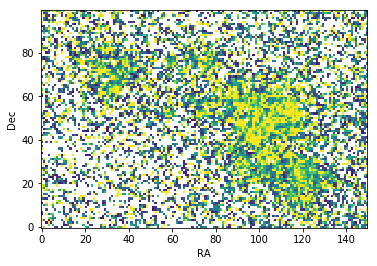

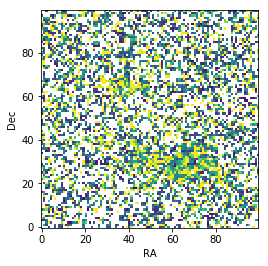

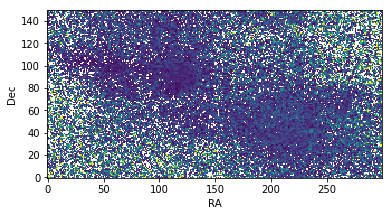

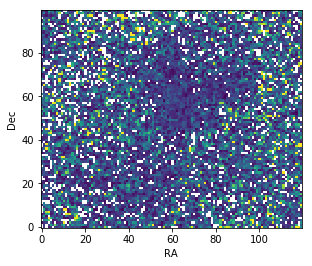

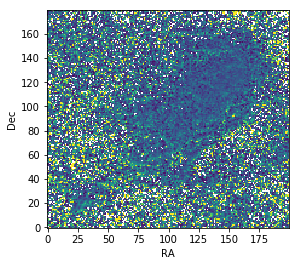

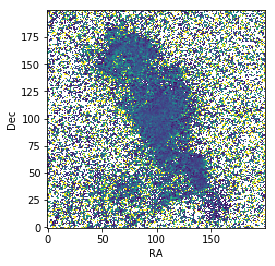

In [3]:
# creating the 126/164 ratio for each of the cutouts and saving that value to fits file
# written mostly on my own, probaly missing some stuff

noise_126 = 0.0264083
noise_128 = 0.0290156
noise_164 = 0.0333493

im126 = fits.open('FITS_images/HST/126_dash_filled_final.fits')
hdu_126_flam = im126[0].header['PHOTFLAM']
hdu_126_bw = im126[0].header['PHOTBW']

im164 = fits.open('FITS_images/HST/164_dash_filled_final.fits')
hdu_164_flam = im164[0].header['PHOTFLAM']
hdu_164_bw = im164[0].header['PHOTBW']

knots = [1,2,3,4,5,6]
for i in range(len(knots)):
    im_126cut = 'FITS_images/cutouts/126_knot'+str(knots[i])+'.fits'
    im_164cut = 'FITS_images/cutouts/164_knot'+str(knots[i])+'_shift.fits'

    hdu_126 = fits.open(im_126cut)
    hdu_126_data = hdu_126[1].data
    #hdu_126_data = hdu_126[1].data * hdu_126_flam * hdu_126_bw
    wcs_126 = WCS(hdu_126[1].header)
    #noise_126 = noise_126 * hdu_126_flam * hdu_126_bw

    hdu_164 = fits.open(im_164cut)
    hdu_164_data = hdu_164[1].data
    #hdu_164_data = hdu_164[1].data * hdu_164_flam * hdu_164_bw
    #noise_164 = noise_164 * hdu_164_flam * hdu_164_bw
    
    perc = 0.1 #this tends to work?? Maybe can change...
    hdu_126_data[hdu_126_data < noise_126*perc] = np.nan   
    hdu_164_data[hdu_164_data < noise_164*perc] = np.nan

    data_ratio = np.divide(hdu_126_data, hdu_164_data, out=np.zeros_like(hdu_164_data), where=hdu_164_data!=0.)
    #plt.imshow(data_ratio, vmin = 0, vmax = 1)
    implot(data_ratio, wcs_126, wcscond=False, vmax_p=2) 

    hdu_126[1].data = data_ratio
    #hdu_126[1].header.update(wcscut.to_header())
    hdu_126[1].writeto('FITS_images/cutouts/ratio_knot'+str(i+1)+'.fits', overwrite=True)

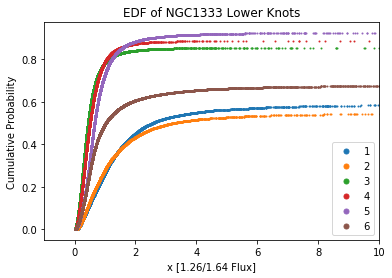

In [4]:
# Amanda add in to create the EDF with premade cutouts
knots = [1,2,3,4,5,6]
for i in range(len(knots)):
    hdu1 = fits.open('FITS_images/cutouts/ratio_knot'+str(i+1)+'.fits')  #import image
    w = WCS(hdu1[1].header)   #get wcs coords
    data = hdu1[1].data   #getting data from hdu
    hdu1.close()
    
    flat_data = data.flatten()
    xedf, yedf = edf_calc(flat_data)
    plt.scatter(xedf, yedf, label = str(i+1), s = 1)

# plt.title('EDF of HH 7-11 Scattered Light Regions')
plt.title('EDF of NGC1333 Lower Knots')
plt.xlabel('x [1.26/1.64 Flux]')
plt.ylabel('Cumulative Probability')
plt.xlim(-1, 10)
plt.legend(loc='best', markerscale = 5)

C:\Users\abroa\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
C:\Users\abroa\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


knee:  0.65089524
count:  5626.0
0finder:  [0]
0finder:  0.6501002907752991
knee:  0.69032115
count:  3262.0
0finder:  [198]
0finder:  0.7162790894508362
knee:  0.93222576
count:  8027.0
0finder:  [198]
0finder:  0.6582993268966675
knee:  1.1068327
count:  3071.0
0finder:  [198]
0finder:  0.6757628321647644
knee:  0.7731074
count:  15057.0
0finder:  [198]
0finder:  0.6560189723968506
knee:  0.8423509
count:  11150.0
0finder:  [198]
0finder:  0.6588733792304993


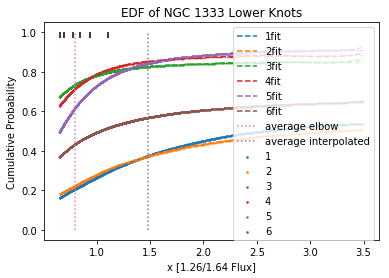

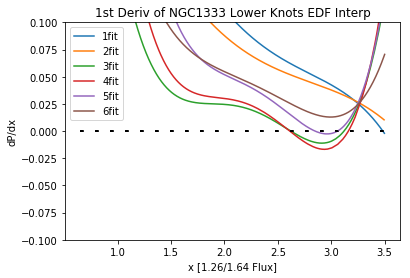

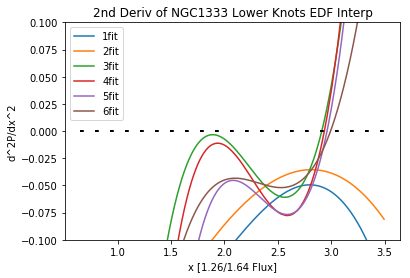

In [5]:
# taken from Adam's hh711_scatter_edf code, adapted slightly

#this cell tries to FIT the EDF turnoff
#the EDF turnoff corresponds to a flattening in the EDF
#unforunately, I always get this vertical bar, which cannot be fit, so I have to restrict my data range

from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
from kneed import KneeLocator
import numpy as np
import pandas as pd
import sys
from scipy.interpolate import UnivariateSpline


# Amanda add in to create the EDF with premade cutouts
knots = [1,2,3,4,5,6]
for i in range(len(knots)):
    hdu1 = fits.open('FITS_images/cutouts/ratio_knot'+str(i+1)+'.fits')  #import image
    w = wcs.WCS(hdu1[1].header)   #get wcs coords
    data = hdu1[1].data   #getting data from hdu
    hdu1.close()
    
    flat_data = data.flatten()
    xedf, yedf = edf_calc(flat_data)
    
    idx = (xedf>0.65)*(xedf<3.5)  #returning mask for array indexing, original: idx = (xedf>0.65)*(xedf<3.5)
    yedf = yedf[idx]
    xedf = xedf[idx]
    
    
    
    '''
    #a0 and af are meant to take ranges of values...a0 is the initial value and af is the final value
    #I had to guess and plot to find these...
    #the if conds are picking out each knot
    #unfortunately, each data has a different range and number of values 
    #edf_calc should sort the data, so moving up af for example should be fine
    af = int(1e7)
    if i == 11-7:
        a0 = int(8e3)
    elif i == 8-7: 
        a0 = int(8.2e3)
    elif i == 3: #10
        a0 = int(1.25e4)
#         af = int(1e21)
    elif i == 2: #9
        a0 = int(3.5e3)
    else: #7
        a0 = int(1.95e4)
        
    '''
        
        
    #plotting only a limited range of data to check
    plt.figure(111)
#     plt.scatter(xedf[a0:af], yedf[a0:af], label =  str(i+7), s = 0.1) 
    plt.scatter(xedf, yedf, label =  str(i+1), s = 0.1) 

    
    #one method of fitting the turnoff:
    #trying kneed - an elbow point finder package
    #can adjust curve and direction as per their docs: https://pypi.org/project/kneed/
#     kn = KneeLocator(xedf[a0:af], yedf[a0:af], curve='concave', direction='increasing')
    kn = KneeLocator(xedf, yedf, curve='concave', direction='increasing')
    print('knee: ', kn.knee) #the output directly gives a possible x-value for the turnoff
    
    
    
    #we can also interpolate the data, but I needed to pick a portion of the data for that
    #producing smaller list of values that can be fit with a function
#     arr = np.array([xedf[a0:af], yedf[a0:af]])
    arr = np.array([xedf, yedf])
#     arrx_uni = np.unique(arr, axis=1)
#     arr_nodup = np.unique(arrx_uni, axis=1)
    
    #old
#     arrx_lim = np.array([i for i in arr[0] if i < 4.5])  #another way of restricting x-values
#     arry_lim = arr[1][:len(arrx_lim)]  #restricting y values too?
    
    #based on nonlinfits
    arrx_lim = arr[0]
    arry_lim = arr[1]
    
    #creating smooth curve - interpolating also can fit the data
    dim = 5
    pfit = np.polyfit(arrx_lim, arry_lim, dim)
    f = np.poly1d(pfit)  #interpolating function to be used
    plt.plot(arrx_lim, f(arrx_lim), linestyle='--', label= str(i+1)+'fit')
    plt.plot([kn.knee, kn.knee], [0.97,1], color='black', linestyle='--', dashes=(4, 8))
    
    #plotting derivative to find turning point...
    plt.figure(112)
    deriv_f = np.polyder(f)  #interpolating derivative of function to be used
    plt.plot(arrx_lim, deriv_f(arrx_lim), label= str(i+1)+'fit')
    plt.plot(arrx_lim, [0]*arrx_lim, color = 'black', linestyle='--', dashes=(2, 8))
    
    #and the second derivative
    plt.figure(113)
    deriv2_f = np.polyder(deriv_f)  #interpolating 2nd derivative of function to be used
    plt.plot(arrx_lim, deriv2_f(arrx_lim), label= str(i+1)+'fit')
    plt.plot(arrx_lim, [0]*arrx_lim, color = 'black', linestyle='--', dashes=(2, 8))

    
    #finding min values of derivs, which correspond to crit pts, inflection pts (~ turnoff)
    #...figures out where 0 reddening ratio is
#     setted_list = deriv_f(arrx_lim)
    setted_list = deriv2_f(arrx_lim)
    minimum = float("inf")
    
    
    #finding approx spot of turnoff, though need to refine it by eye
    #I found the indexing determined by "count" is off by 1 or 2 for whatever reason
    value_chosen = 0.
    count = 0.
    for val in setted_list:
        count += 1
        if abs(val - value_chosen) < minimum and count < 200:
            final_value = val
            minimum = abs(val - value_chosen)
    
    print('count: ', count)
    print('0finder: ', [np.where(setted_list == final_value)[0][0]])
    print('0finder: ', arrx_lim[np.where(setted_list == final_value)[0][0]])

    
    #settling on chosen spot confirming with approx location from graph
    #I use count to find this
#     if i == 11-7:
#         print('chosen root: ', arrx_lim[98])
#         plt.plot([arrx_lim[98], arrx_lim[98]], [-0.01, 0.01], color='black', linestyle='--')

#     elif i == 8-7: 
#         print('chosen root: ', arrx_lim[193])
#         plt.plot([arrx_lim[193], arrx_lim[193]], [-0.01, 0.01], color='black', linestyle='--')

#     elif i == 9-7: #9
#         print('chosen root: ', np.mean(np.array([arrx_lim[98], arrx_lim[99]])))
#         avg = np.mean(np.array([arrx_lim[98], arrx_lim[99]]))
#         plt.plot([avg, avg], [-0.01, 0.01], color='black', linestyle='--')

#     elif i == 10-7: #10
#         print('chosen root: ', np.mean(np.array([arrx_lim[96], arrx_lim[97]])))
#         avg = np.mean(np.array([arrx_lim[96], arrx_lim[97]]))
#         plt.plot([avg, avg], [-0.01, 0.01], color='black', linestyle='--')

#     else: #7
#         print('chosen root: ', arrx_lim[487])
#         plt.plot([arrx_lim[487], arrx_lim[487]], [-0.01, 0.01], color='black', linestyle='--')

    
    
    
#formatting figures and legends
plt.figure(111)
# plt.plot([1.911, 1.911], [0.97,1], label ='average elbow', linestyle=':')
# plt.plot([2.82, 2.82], [0.97,1], label ='average elbow', linestyle=':')
plt.plot([0.8, 0.8], [0.,1], label ='average elbow', linestyle=':') #from new try with non linear fits
plt.plot([1.48, 1.48], [0.,1], label ='average interpolated', linestyle=':') #from new try with non linear fits

plt.title('EDF of NGC 1333 Lower Knots')
plt.xlabel('x [1.26/1.64 Flux]')
plt.ylabel('Cumulative Probability')
# plt.xlim(0.5,3.5)
# plt.ylim(0,1.1)
plt.legend(loc='best', markerscale = 5)
# plt.savefig('../EDFs/HH711EDF.png')
#plt.savefig('../EDFs/HH711elbow.png')

plt.figure(112)
plt.title('1st Deriv of NGC1333 Lower Knots EDF Interp')
plt.xlabel('x [1.26/1.64 Flux]')
plt.ylabel('dP/dx')
# plt.xlim(0.5,3.5)
plt.ylim(-0.1, 0.1)
plt.legend(loc='best', markerscale = 5)
#plt.savefig('../EDFs/HH711deriv.png')

plt.figure(113)
plt.title('2nd Deriv of NGC1333 Lower Knots EDF Interp')
plt.xlabel('x [1.26/1.64 Flux]')
plt.ylabel('d^2P/dx^2')
# plt.xlim(0.5,3.5)
plt.ylim(-0.1, 0.1)
plt.legend(loc='best', markerscale = 5)
#plt.savefig('../EDFs/HH711deriv2.png')